In [2]:
# import
import os
import plotly.graph_objects as go
import plotly.express as px

# frontend
import numpy as np
from spatialmath import *
import cv2
import matplotlib.pyplot as plt

# backend
import gtsam
from gtsam.symbol_shorthand import L, X

# our slam implementation
from minslam.data_loader import TartanAirLoader
from minslam.frontend import Frontend
from minslam.params import Params
from minslam.backend import Backend
from minslam.camera import PinholeCamera

--- Added keyframe 0 (seq id: 100) ---
extracting features: 300 (expected 300)


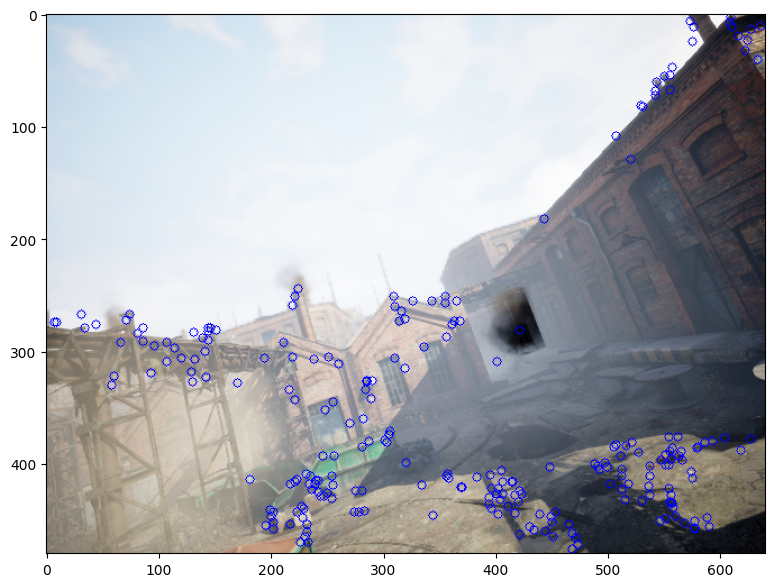

In [3]:
# bruteforce

# load a trajectory
dataset = TartanAirLoader('../data/P006/')
dataset.load_ground_truth()
dataset.set_odometry(dataset.gt)
dataset.set_curr_index(100)

# load the dataset
params = Params('../params/tartanair.yaml')
params['frontend']['keyframe']['threshold'] = 1
params['frontend']['match']['matcher'] = 'bruteforce'
params['frontend']['ransac']['method'] = 'fundamental'
frontend = Frontend(params)


# get results from frontend
def run_frontend_once(frontend):
    pose = dataset.read_current_ground_truth()
    while not frontend.keyframe_selection(pose):
        if not dataset.load_next_frame():
            break
        pose = dataset.read_current_ground_truth()
    color, depth = dataset.read_current_rgbd()
    frontend.add_keyframe(pose, color, depth, dataset.curr_index)
    print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
    more_points_n = params['frontend']['feature']['number']
    frontend.extract_features(more_points_n, append_mode=False)
    print('extracting features:', len(frontend.curr_frame.keypoints), f'(expected {more_points_n})')
    if frontend.frame_id > 0:
        frontend.match_features()
        frontend.eliminate_outliers()
    frontend.assign_global_id()
    # frontend.plot_matches(with_global_id=True)
    return frontend.curr_frame

# get two frames
plt.figure(figsize=(15,7))
frontend_frame1 = run_frontend_once(frontend)
im = frontend.plot_matches(with_global_id=True)
# frontend_frame2 = run_frontend_once(frontend)
# im = frontend.plot_matches(with_global_id=True)

--- Added keyframe 1 (seq id: 130) ---
extracting features: 300 (expected 300)


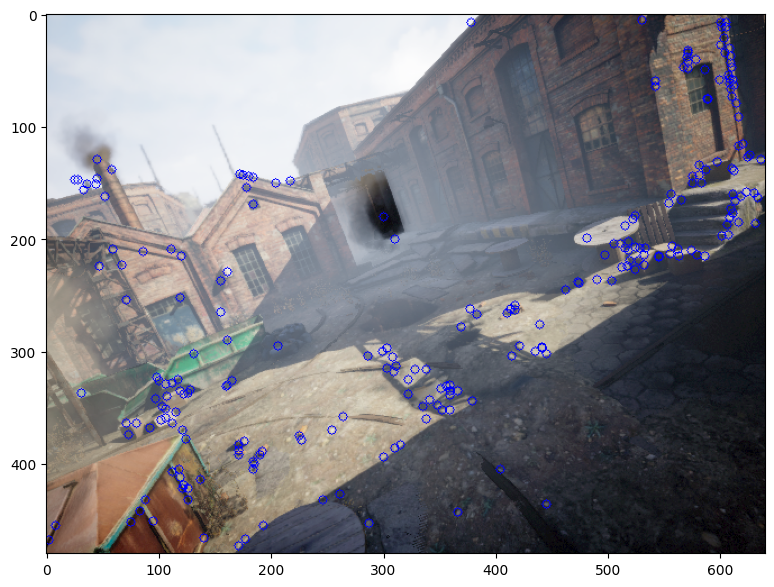

In [4]:
plt.figure(figsize=(15,7))
frontend_frame2 = run_frontend_once(frontend)
im = frontend.plot_features()

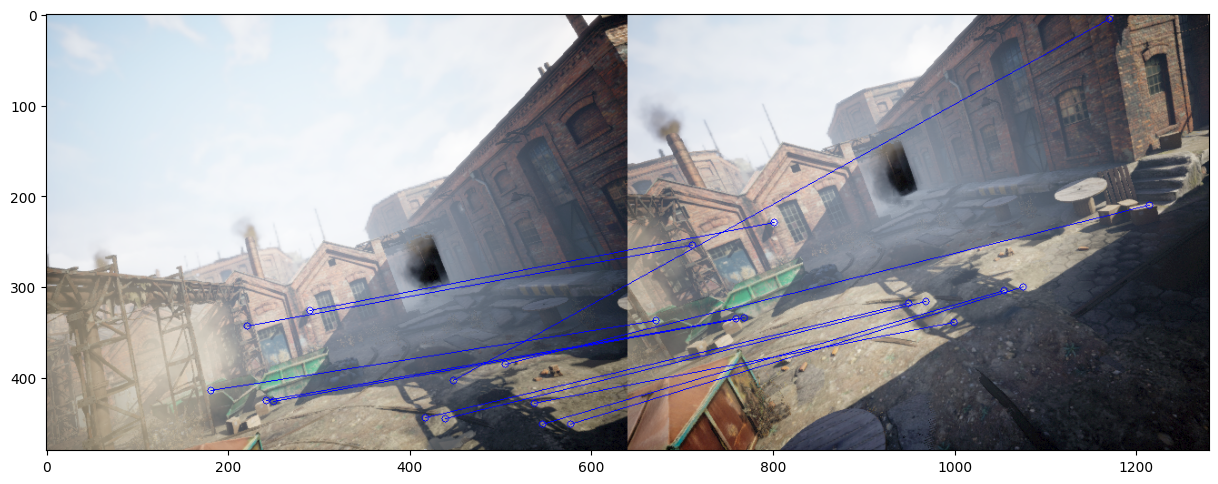

In [5]:
plt.figure(figsize=(15,7))
im = frontend.plot_matches()

In [33]:
T = np.zeros((4,4))
T[:3,:3] = frontend.ransac_r
T[:3,3] = frontend.ransac_t.flatten()
T[3,3] = 1
rel_pose_ransac = SE3(T)
rel_pose_odom = frontend_frame2.odom_pose.inv() * frontend_frame1.odom_pose
(rel_pose_ransac.inv() * rel_pose_odom).log(True), rel_pose_ransac, rel_pose_odom

(array([ 0.02284507,  0.00368153,  0.00377509, -0.00018576, -0.00146882,
         0.00094965]),
    0.9234   -0.03617  -0.3821    0.661     
  -0.08046   0.9552   -0.2849   -0.2095    
   0.3753    0.2938    0.8791   -0.5407    
   0         0         0         1         
,
    0.9228   -0.03697  -0.3834    0.6805    
  -0.07997   0.9553   -0.2846   -0.2089    
   0.3768    0.2933    0.8786   -0.5277    
   0         0         0         1         
)

In [ ]:
# optical flow

# load a trajectory
dataset = TartanAirLoader('../data/P006/')
dataset.load_ground_truth()
dataset.set_odometry(dataset.gt)
dataset.set_curr_index(100)

# load the dataset
params = Params('../params/tartanair.yaml')
params['frontend']['keyframe']['threshold'] = 1
params['frontend']['match']['matcher'] = 'opticalflow'
frontend = Frontend(params)


# get results from frontend
def run_frontend_once(frontend):
    pose = dataset.read_current_ground_truth()
    while not frontend.keyframe_selection(pose):
        if not dataset.load_next_frame():
            break
        pose = dataset.read_current_ground_truth()
    color, depth = dataset.read_current_rgbd()
    frontend.add_keyframe(pose, color, depth, dataset.curr_index)
    print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
    if frontend.frame_id > 0:
        frontend.match_features()
        frontend.eliminate_outliers()
    more_points_n = params['frontend']['feature']['number']-len(frontend.curr_frame.points)
    print('current point number:', len(frontend.curr_frame.points))
    if more_points_n>0:
        print('extracting more features:', more_points_n)
        frontend.extract_features(more_points_n, append_mode=True)
    frontend.assign_global_id()
    # frontend.plot_matches(with_global_id=True)
    return frontend.curr_frame

# get two frames
frontend_frame1 = run_frontend_once(frontend)
frontend_frame2 = run_frontend_once(frontend)

plt.figure(figsize=(20,10))
im = frontend.plot_matches(with_global_id=True)